In [1]:
import re
import json
import traceback
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Concatenate, Dropout, Attention
from tensorflow.keras import backend as K

In [2]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [3]:
def expand_contractions_and_clean(text):
    # mapping of contractions to their expanded forms
    contractions = {
        r"i'm": "i am",
        r"he's": "he is",
        r"she's": "she is",
        r"that's": "that is",
        r"what's": "what is",
        r"where's": "where is",
        r"\'ll": " will",
        r"\'ve": " have",
        r"\'re": " are",
        r"\'d": " would",
        r"won't": "will not",
        r"can't": "can not",
    }
    
    text = text.lower()
    
    # expand contractions
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)
    
    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    return text

In [4]:
model = load_model('chatbot.h5', custom_objects={'AttentionLayer': AttentionLayer})
model.summary()

Metal device set to: Apple M1


2024-08-02 10:47:45.048789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-02 10:47:45.049193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input_layer (InputLaye  [(None, 23)]        0           []                               
 r)                                                                                               
                                                                                                  
 encoder_input_layer (InputLaye  [(None, 23)]        0           []                               
 r)                                                                                               
                                                                                                  
 embedding (Embedding)          (None, 23, 100)      965800      ['encoder_input_layer[0][0]',    
                                                                  'decoder_input_layer[0][0]']

In [5]:
#load model history
with open('chatbot_history.json', 'r') as f:
    history = json.load(f)

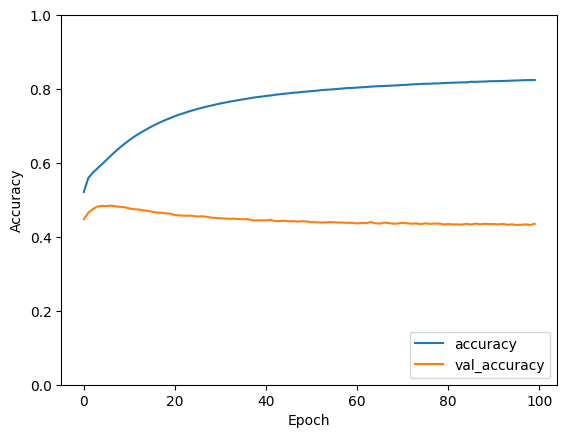

In [6]:
plt.plot(history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [7]:
#load vocab
with open('vocab.json', 'r', encoding='utf-8') as f:
    vocab = json.load(f)
    
inverse_vocab = {count: word for word, count in vocab.items()}
len(vocab)

9657

In [8]:
MAX_LENGTH = 23
LSTM_UNITS = 256
EMBEDDING_DIMENSION = 100
VOCAB_SIZE = len(vocab)

In [9]:
embedding_index = {}
with open('../dataset/glove/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
    f.close()

print("GloVe Loded!")

GloVe Loded!


In [10]:
def embedding_matrix_creater(dimension, word_index):
    embedding_matrix = np.zeros((len(word_index)+1, dimension))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = embedding_matrix_creater(dimension=EMBEDDING_DIMENSION, word_index=vocab)

In [11]:
embedding_layer = Embedding(VOCAB_SIZE+1, 
                  EMBEDDING_DIMENSION, 
                  input_length=MAX_LENGTH,
                  trainable=True)

embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

In [12]:
#building model
encoder_input_layer = Input(shape=(MAX_LENGTH, ), name='encoder_input_layer')

encoder_embedding_layer = embedding_layer(encoder_input_layer)
encoder_bidirectional_lstm_layer = Bidirectional(LSTM(LSTM_UNITS, return_state=True, dropout=0.05, return_sequences = True, name='encoder_lstm_layer'), name='encoder_bidirectional_lstm')

encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bidirectional_lstm_layer(encoder_embedding_layer)

state_h = Concatenate(name='state_h_concat')([forward_h, backward_h])
state_c = Concatenate(name='state_c_concat')([forward_c, backward_c])

encoder_states = [state_h, state_c]

decoder_input_layer = Input(shape=(MAX_LENGTH, ), name='decoder_input_layer')
decoder_embedding_layer = embedding_layer(decoder_input_layer)
decoder_lstm_layer = LSTM(LSTM_UNITS * 2, return_state=True, return_sequences=True, dropout=0.05, name='decoder_lstm_layer')
decoder_outputs, _, _ = decoder_lstm_layer(decoder_embedding_layer, initial_state=encoder_states)

# attention
attention_layer = AttentionLayer(name='attention_layer')
attention_output, attention_state = attention_layer([encoder_outputs, decoder_outputs])
decoder_concat_input_layer = Concatenate(axis=-1, name='decoder_concat_input_layer')([decoder_outputs, attention_output])

decoder_dense_layer = Dense(VOCAB_SIZE, activation='softmax', name='decoder_dense_layer')
final_output_layer = decoder_dense_layer(decoder_concat_input_layer)

model = Model([encoder_input_layer, decoder_input_layer], final_output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input_layer (InputLaye  [(None, 23)]        0           []                               
 r)                                                                                               
                                                                                                  
 encoder_input_layer (InputLaye  [(None, 23)]        0           []                               
 r)                                                                                               
                                                                                                  
 embedding (Embedding)          (None, 23, 100)      965800      ['encoder_input_layer[0][0]',    
                                                                  'decoder_input_layer[0][0]']

In [13]:
#load saved_weights
model.load_weights('chatbot_weights.h5')

In [14]:
#model inference for generating responses
inference_encoder_model = Model(encoder_input_layer, [encoder_outputs, encoder_states])

inference_decoder_state_input_h = Input(shape=( LSTM_UNITS * 2,))
inference_decoder_state_input_c = Input(shape=( LSTM_UNITS * 2,))

inference_decoder_states_inputs = [inference_decoder_state_input_h, inference_decoder_state_input_c]


inference_decoder_outputs, inference_state_h, inference_state_c = decoder_lstm_layer(decoder_embedding_layer , initial_state=inference_decoder_states_inputs)


inference_decoder_states = [inference_state_h, inference_state_c]

inference_decoder_model = Model(
    [decoder_input_layer, inference_decoder_states_inputs],
    [inference_decoder_outputs] + inference_decoder_states
)

In [15]:
separator = '-'
input_text = ""
while input_text != 'exit':
    input_text = input("YOU : ")
    if(input_text == 'exit'):
        print("Bye! Talk to you later.")
    else:
        try:
            if separator in input_text:
                prompt, context = input_text.split(separator, 1)  # split only on the first occurrence
            else:
                prompt = input_text
                context = "joyful"
                
            input_cleaned = expand_contractions_and_clean(prompt.strip()) + ' <SEP> ' + context.strip()
            input_cleaned = [input_cleaned]
            
            text = []
            for x in input_cleaned:
                lst = []
                for y in x.split():
                    try:
                        lst.append(vocab[y])
                    except:
                        lst.append(vocab['<OUT>'])
                text.append(lst)
            text = pad_sequences(text, MAX_LENGTH, padding='post')
    
            inference_encoder_output, inference_encoder_states = inference_encoder_model.predict( text )
    
            empty_target_seq = np.zeros( ( 1 , 1) )
            empty_target_seq[0, 0] = vocab['<SOS>']
            stop_condition = False
            decoded_translation = ''
    
            while not stop_condition :
                inference_decoder_outputs , h , c = inference_decoder_model.predict([ empty_target_seq ] + inference_encoder_states )

                #attention part
                inference_attention_output, inference_attention_states = attention_layer([inference_encoder_output, inference_decoder_outputs])
                inference_decoder_concat_input = Concatenate(axis=-1)([inference_decoder_outputs, inference_attention_output])
                inference_decoder_concat_input = decoder_dense_layer(inference_decoder_concat_input)
    
                sampled_word_index = np.argmax( inference_decoder_concat_input[0, -1, :] )
                sampled_word = inverse_vocab[sampled_word_index] + ' '
    
                if sampled_word != '<EOS> ':
                    decoded_translation += sampled_word           
    
                if sampled_word == '<EOS> ' or len(decoded_translation.split()) > MAX_LENGTH:
                    stop_condition = True
    
                empty_target_seq = np.zeros( ( 1 , 1 ) )  
                empty_target_seq[ 0 , 0 ] = sampled_word_index
                inference_encoder_states = [ h , c ] 
    
            print("CHATBOT : ", decoded_translation )
    
        except Exception as e:
            #print("I couldn't get you. Please try again.")
            print(e)
            

YOU :  I failed my exam - disappointed


2024-08-02 11:05:07.037959: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-08-02 11:05:07.809299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-02 11:05:07.958797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-02 11:05:07.983232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 169ms/step


2024-08-02 11:05:08.359660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-02 11:05:08.391873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step
CHATBOT :  i didnt ask the exam there all the time 


YOU :  I lost my pet - sad


1/1 [==============================] - 0s 10ms/step
CHATBOT :  i lost my pet turtle i lost my dog 


YOU :  My friends forgot my birthday - lonely


1/1 [==============================] - 0s 9ms/step
CHATBOT :  my friends wife were invited some of the best days of a week i am really sorry to him 


YOU :  I finished my project early - proud


1/1 [==============================] - 0s 9ms/step
CHATBOT :  i finished my work project today 


YOU :  I'm confident about my skills - confident


1/1 [==============================] - 0s 9ms/step
CHATBOT :  i am not able to call the call i if i work i am going to call my boss for a long <PAD> <PAD> 


YOU :  I feel betrayed by my friend - hurt


1/1 [==============================] - 0s 10ms/step
CHATBOT :  i have seen my friends in a <OUT> country 


YOU :  I didn't do well on my exam - disappointed


1/1 [==============================] - 0s 9ms/step
CHATBOT :  i didnt get an extra exam offer but didnt do that 


YOU :  I'm nervous about my presentation - anxious


1/1 [==============================] - 0s 9ms/step
CHATBOT :  i am nervous about my spouse giving it in front of a field that i have applied 


YOU :  I'm struggling to understand this topic - frustrated


1/1 [==============================] - 0s 11ms/step
CHATBOT :  i am starting my <OUT> soon law and what i am talking about it 


YOU :  I'm worried about failing this course - terrified


1/1 [==============================] - 0s 9ms/step
CHATBOT :  i am worried i will have to walk through one of my classes this week 


YOU :  bye


1/1 [==============================] - 0s 10ms/step
CHATBOT :  pet <OUT> red and <OUT> <OUT> 


YOU :  exit


Bye! Talk to you later.
